# __Financial Prediction research (LSTM)__


Research about financial prediction on cryptocurrency markets.

2018

![Banner Smile](smile_banner.png)

In [1]:
# base import
import pandas as pd
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import os
import sys
import keras
import json
import yaml

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from IPython.display import clear_output
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Embedding, LSTM, Flatten,Dense, Dropout, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from IPython.display import clear_output
import h5py

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='solarizedd')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print("Library version:")
print("\t-  pandas: {}".format(pd.__version__))
print("\t-  numpy: {}".format(np.__version__))
print("\t-  sklearn: {}".format(sk.__version__))
print("\t-  matplotlib: {}".format(matplot.__version__))
print("\t-  python: {}".format(sys.version[:sys.version.find('(') - 1]))

Library version:
	-  pandas: 0.23.0
	-  numpy: 1.14.3
	-  sklearn: 0.19.1
	-  matplotlib: 2.2.2
	-  python: 3.6.5 |Anaconda, Inc.|


# Normalisation

This class apply logarithm and a normalization(MinMax | StandarScale | Normalizer_l1 | Normalizer_l2).

In [3]:
#normalize class
class Normalisation:
    def __init__(self, data):
        self.__marketList = [e["name"] for e in data]
        self.__data = [e["data"] for e in data]
        self.__format = False
        
        
    def __norme_MinMax(self, target, numerical_markets):
        scaler = MinMaxScaler()
        normalized_markets = []
        if target == "all":
            for market in numerical_markets:
                columns_name= market.columns
                market[columns_name] = scaler.fit_transform(market[columns_name])
                normalized_markets.append(market.reset_index())
            self.__normalizeData = normalized_markets
        else:
            for marketName, market in zip(self.__marketList, numerical_markets):
                if marketName in target:
                    columns_name= market.columns
                    market[columns_name] = scaler.fit_transform(market[columns_name])
                    normalized_markets.append(market.reset_index())
            self.__normalizeData = normalized_markets
    
    def __norme_StandarScaler(self, target, numerical_markets):
        scaler = StandardScaler()
        normalized_markets = []
        if target == "all":
            for market in numerical_markets:
                columns_name= market.columns
                market[columns_name] = scaler.fit_transform(market[columns_name])
                normalized_markets.append(market.reset_index())
            self.__normalizeData = normalized_markets
        else:
            for marketName, market in zip(self.__marketList, numerical_markets):
                if marketName in target:
                    columns_name= market.columns
                    market[columns_name] = scaler.fit_transform(market[columns_name])
                    normalized_markets.append(market.reset_index())
            self.__normalizeData = normalized_markets
    
    def __norme_Normalizer_l(self, target, numerical_markets, norme):
        scaler = Normalizer(norme)
        normalized_markets = []
        if target == "all":
            for market in numerical_markets:
                columns_name= market.columns
                market[columns_name] = scaler.fit_transform(market[columns_name])
                normalized_markets.append(market)
            self.__normalizeData = normalized_markets
        else:
            for marketName, market in zip(self.__marketList, numerical_markets):
                if marketName in target:
                    columns_name= market.columns
                    market[columns_name] = scaler.fit_transform(market[columns_name])
                    normalized_markets.append(market.reset_index())
            self.__normalizeData = normalized_markets
            
    def fit(self, normeType, featuresList, target="all"):
        numerical_markets = []
        for market in self.__data:
            numerical_markets.append(market[featuresList]._get_numeric_data())
        if normeType == "MinMax":
            print("MinMax Normalization.")
            self.__norme_MinMax(target, numerical_markets)
            
        elif normeType == "StandarScale":
            print("StandarScale Normalization.")
            self.__norme_StandarScaler(target, numerical_markets)
        
        elif normeType == "Normalizer_l1":
            print("Normalizer_l1 Normalization.")
            self.__norme_Normalizer_l(target, numerical_markets, "l1")
        
        elif normeType == "Normalizer_l2":
            print("Normalizer_l2 Normalization.")
            self.__norme_Normalizer_l(target, numerical_markets, "l2")
    
    #return the data normalize
    def get_normalize_data(self, idx):
        return self.__normalizeData[idx]

# PEAKS

This function detect peaks with a delta.

In [4]:
# Peaks detection function
def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [5]:
# Frame labelization functions
def setSell(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 1.0
    for i in peaksmin:
        if i[0] == idx:
            return 0.0
    return 0.0

def setWait(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 0.0
    for i in peaksmin:
        if i[0] == idx:
            return 0.0
    return 1.0

def setBuy(idx, peaksmax, peaksmin):
    for i in peaksmax:
        if i[0] == idx:
            return 0.0
    for i in peaksmin:
        if i[0] == idx:
            return 1.0
    return 0.0

def frame_labelization(frame_base, maxp, minp, data):
    frame_base["wait"] = [setWait(d, maxp, minp) for d in range(len(data[0]["data"]))]
    frame_base["sell"] = [setSell(d, maxp, minp) for d in range(len(data[0]["data"]))]
    frame_base["buy"] = [setBuy(d, maxp, minp) for d in range(len(data[0]["data"]))]
    return frame_base

In [6]:
# Format Data functions
def generate_data(dataset, timestep, xcols, ycols):
    dx, dy = [], []
    for i in range(len(dataset) - timestep):
        a = dataset.iloc[i : i + timestep][xcols]
        dx.append(np.array(a))
        dy.append(dataset.iloc[i + timestep  - 1][ycols])
    return np.array(dx), np.array(dy)

def split_train(frame, train_per, test_per, timestep, xcols, ycols, balance=False):
    x_tmp, y_tmp = generate_data(frame, timestep, xcols, ycols)
    if balance is True:
        x_tmp, y_tmp =  balancelabelisation(x_tmp, y_tmp)
    train_size = int(x_tmp.shape[0] * train_per)
    test_size = int(x_tmp.shape[0] * test_per) + train_size

    x_train = x_tmp[: train_size]
    y_train = y_tmp[: train_size]
    x_test = x_tmp[train_size : test_size]
    y_test = y_tmp[train_size : test_size]
    return x_train, y_train, x_test, y_test

def balancelabelisation(frame, label):
    buy = int(label[:,0].sum())
    sell = int(label[:,1].sum())
    wait = int(label[:,2].sum())
    need_delete = wait - min(sell, buy)
    tab_wait = [i for i, l in enumerate(label)if l[2] == 1]
    rand_delete = np.random.choice(tab_wait, need_delete, replace=False)
    final_frame = np.delete(frame, rand_delete, axis=0)
    final_label = np.delete(label, rand_delete, axis=0)
    final_frame = np.array(final_frame)
    final_label = np.array(final_label)
    return final_frame, final_label

In [7]:
# Neural functions

def lstmNeuronsNumber(frame, setting):
    Ni = len(setting["labelisation_features_name"])
    No = len(setting["labelisation_labels_name"])
    Ns = frame.shape[0]
    a = setting["delta_neurons_numbers"]
    return int(Ns / (a * (Ni + No)))

In [8]:
class PlotRealTime(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, 'g', label="accuracy")
        plt.plot(self.x, self.val_acc, 'r', label="validation accuracy")
        plt.legend()
        plt.title("Accuracy percentage")
        plt.grid()
        plt.show()
        
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.title("Losses percentage")
        plt.grid()
        plt.show()

If you have some troubles with 'get_data()' or 'tickers.csv', read the Notebook section in the README.md.

file :  tickers.csv
target :  ['BTC-NEO']


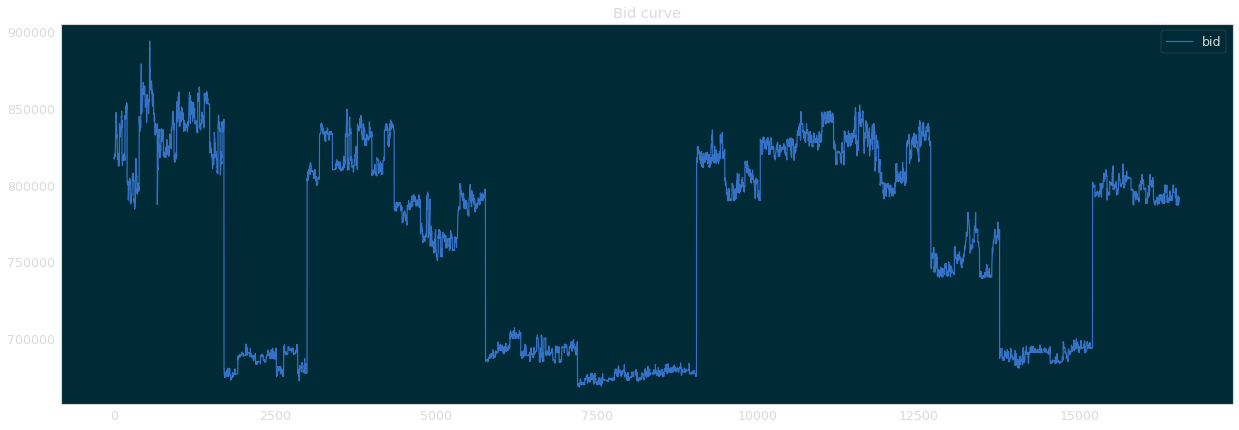

StandarScale Normalization.


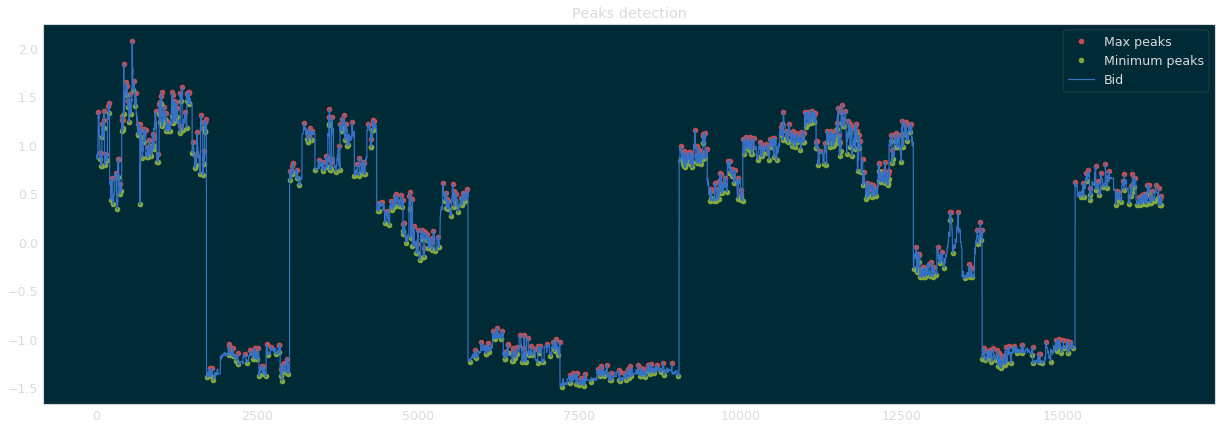

In [9]:
%matplotlib inline

# noramlize: MinMax | StandarScale | Normalizer_l1 | Normalizer_l2 
settings = dict({"ticker_file": "tickers.csv",
                 "markets_target": ["BTC-NEO"],
                 "normalisation_fit_type": "StandarScale",
                 "normalisation_fit_target": "all",
                 "normalisation_target": "bid",
                 "labelisation_disparity": 0.065,
                 "labelisation_features_name": ["ask", "bid", "high", "low", "moy_prev_day"],
                 "labelisation_labels_name": ["buy", "sell", "wait"],
                 "is_balance": True,
                 "split_train": 0.7,
                 "split_test": 0.3,
                 "nb_per_bloc": 50,
                 "delta_neurons_numbers": 2, # delta {2-10}
                 "model_optimizer": "adam",
                 "model_loss": "mse",
                 "model_epoch": 70,
                 "model_batch_size": 50,
                 "model_validation_split": 0.1,
                 "model_suffle": True,
                 "model_evaluate_batch_size": 100
                })

# GET DATA
data = get_data(settings["ticker_file"], settings["markets_target"])

# Display
fig = plt.figure(figsize=(21,7))
data[0]["data"]["bid"].plot(label="bid", title="Bid curve")
plt.grid()
plt.legend()
plt.show()

# NORMALIZATION OF THE DATA
norm = Normalisation(data)
all_normalize_data = norm.fit(settings["normalisation_fit_type"], settings["labelisation_features_name"], settings["normalisation_fit_target"])
normalize_data = norm.get_normalize_data(0)

# PEAKS DETECTION
peaksmax, peaksmin = peakdet(normalize_data[settings["normalisation_target"]], settings["labelisation_disparity"])

# Display peaks
fig = plt.figure(figsize=(21,7))
plt.plot(peaksmax[:,0], peaksmax[:, 1], 'ro', label="Max peaks")
plt.plot(peaksmin[:,0], peaksmin[:, 1], 'go', label="Minimum peaks")
plt.plot(normalize_data["bid"], label="Bid")
plt.grid()
plt.title("Peaks detection")
plt.legend()
plt.show()

In [10]:
# Frame labelization

# LABELIZATION WITH PEAKS
normalize_data_tmp = frame_labelization(normalize_data, peaksmax, peaksmin, data)

# FORMAT DATA FOR MODEL
x_train, y_train, x_test, y_test = split_train(normalize_data_tmp,
                                                     settings["split_train"],
                                                     settings["split_test"],
                                                     settings["nb_per_bloc"],
                                                     settings["labelisation_features_name"],
                                                     settings["labelisation_labels_name"],
                                                     balance=settings["is_balance"])

In [11]:
# Model declaration
 
# SET NUMBER OF NEURONS
settings["model_lstm_neural"] = lstmNeuronsNumber(x_train, settings)  

# MODEL
model = Sequential()
model.add(LSTM(settings["model_lstm_neural"], input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh',return_sequences=True))
model.add(LSTM(settings["model_lstm_neural"], activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(optimizer=settings["model_optimizer"], loss=settings["model_loss"],metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 58)            14848     
_________________________________________________________________
lstm_2 (LSTM)                (None, 58)                27144     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 177       
Total params: 42,169
Trainable params: 42,169
Non-trainable params: 0
_________________________________________________________________


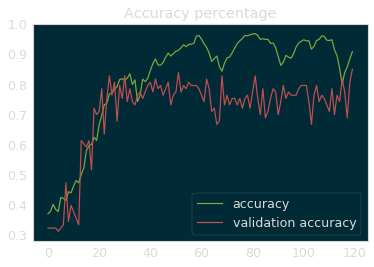

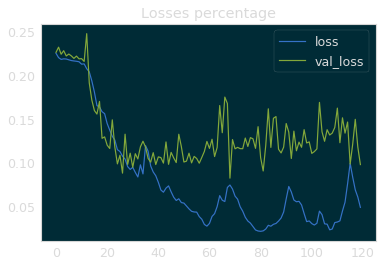

398/398 [==============================] - 0s 232us/step
score: 0.12643598364525704
acc: 0.7462311551798528


In [12]:
# Training

# Plot real-time
plotRT = PlotRealTime()

# Learning stats
def lr(epoch):
    if epoch < 15:
        return 0.010
    if epoch < 40:
        return 0.0095
    if epoch < 55:
        return 0.008
    if epoch < 60:
        return 0.007
    if epoch < 150:
        return 0.01
    return 0.01
# TRAINING
hist = model.fit(x_train,
                 y_train, 
                 epochs=settings["model_epoch"],
                 batch_size=settings["model_batch_size"],
                 validation_split=settings["model_validation_split"],
                 verbose=1,
                 shuffle=settings["model_suffle"],
                 callbacks=[plotRT, LearningRateScheduler(lr, verbose=1)])
# EVALUATE
score , acc = model.evaluate(x_test, y_test, batch_size=settings["model_evaluate_batch_size"], verbose=1)

print("score: {}".format(score))
print("acc: {}".format(acc))

# Prediction
If you change the variable `real_time` to True it will be display steps by steps.

In [13]:
def base_frame_test(frame, train_per, test_per,):
    train_size = int(frame.shape[0] * train_per)
    test_size = int(frame.shape[0] * test_per) + train_size
    return frame.loc[train_size : test_size].reset_index()

test_base = base_frame_test(normalize_data_tmp,
                         settings["split_train"],
                         settings["split_test"])

Capital Start amount :  10
actual action :  sell
capital end :  16.379523573827015


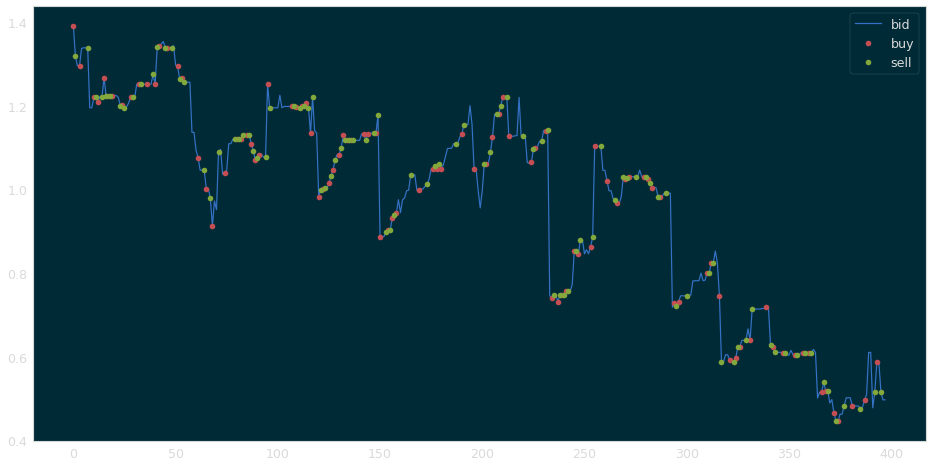

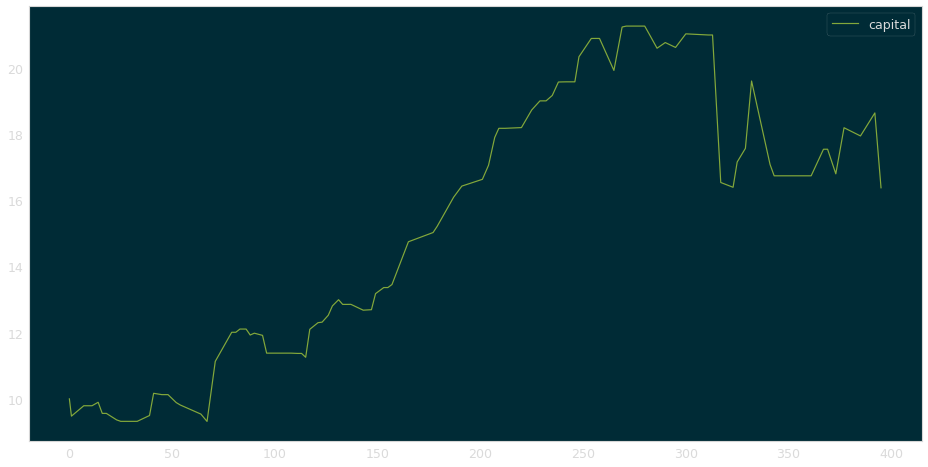

In [15]:
# Prediction Simulation
import time

real_time = False
capital = 10
start_capital = 10
buy_invest = []
sell_invest = []
trade = []
trade_type = None
type_price = None
percentage = None
tab_capital = []
tab_capital.append((0, capital))

for i in range(0, len(x_test)):
    tmp = np.array([x_test[i]])
    prediction = model.predict(tmp)
    if prediction[:, 0] == max(prediction[0]):
        if trade_type is None and capital > 0:
            buy_invest.append((i, test_base["bid"].loc[i]))
            trade.append((i, test_base["bid"].loc[i]))
            trade_type = True
            type_price = "buy"
    if prediction[:, 1] == max(prediction[0]):
        if trade_type == True:
            newCap = trade.pop()
            val = capital / newCap[1]
            newCap = val * test_base["bid"].loc[i]
            capital = newCap
            sell_invest.append((i, test_base["bid"].loc[i]))
            trade_type = None
            tab_capital.append((i, capital))
            type_price = "sell"
            
    if real_time == True:
        time.sleep(1)
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(16,8))
        test_base["bid"].loc[0:i].plot()
        buy_invest_tmp = np.array(buy_invest)
        sell_invest_tmp = np.array(sell_invest)
        print("Capital Start amount : ", start_capital)
        if type_price is not None:
            print("actual action : ", type_price)
        if len(buy_invest)  > 0:
            plt.plot(buy_invest_tmp[:,0], buy_invest_tmp[:,1], "ro", label="buy")
        if len(sell_invest)  > 0:
            plt.plot(sell_invest_tmp[:,0], sell_invest_tmp[:,1], "go", label="sell")
        print("capital : ", capital)
        plt.grid()
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(8,4))
        tab_tmp = np.array(tab_capital)
        plt.plot(tab_tmp[:,0],tab_tmp[:,1], "g", label="capital")
        plt.grid()
        plt.legend()
        plt.show()
        
        
clear_output(wait=True)

time.sleep(1)
fig = plt.figure(figsize=(16,8))
buy_invest_tmp = np.array(buy_invest)
sell_invest_tmp = np.array(sell_invest)

test_base["bid"].loc[0:i].plot()
if len(buy_invest)  > 0:
    plt.plot(buy_invest_tmp[:,0], buy_invest_tmp[:,1], "ro", label="buy")
if len(sell_invest)  > 0:
    plt.plot(sell_invest_tmp[:,0], sell_invest_tmp[:,1], "go", label="sell")

print("Capital Start amount : ", start_capital)
if type_price is not None:
    print("actual action : ", type_price)
print("capital end : ", capital)

plt.grid()
plt.legend()
plt.show()
        
fig = plt.figure(figsize=(16,8))
tab_tmp = np.array(tab_capital)
plt.plot(tab_tmp[:,0],tab_tmp[:,1], "g", label="capital")
plt.grid()
plt.legend()
plt.show()